	# Author: Alexander Staub
	## Last changed: 2025.08.26
	## Purpose: Checking the overlap between Khwan's audio char data and our data


In [13]:
#installing packages
import logging
import pandas as pd
from pprint import pprint
import numpy as np
import json
import os
import glob
from typing import Dict, Any, List, Optional
import gc  # For garbage collection
import csv
import logging
from collections import defaultdict

# plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Set style for better-looking plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [5]:
# loading in the relevant datasets
khwan_audio_chars = pd.read_csv("//bigdata.wu.ac.at/delpero/Data_alexander/data/raw_data/Khwan_Kim/2025_08_matched_spotify_ids.csv")
charts_with_spotify = pd.read_csv("//bigdata.wu.ac.at/delpero/Data_alexander/data/raw_data/Spotify/1980_2000_songs_artists/final_charted_from_spotify_1980_2000.csv")
mb_with_spotify = pd.read_csv("//bigdata.wu.ac.at/delpero/Data_alexander/data/raw_data/Spotify/1980_2000_songs_artists/musicbrainz_spotify_combined_track_artist_final.csv")
charts_no_spotify = pd.read_csv("//bigdata.wu.ac.at/delpero/Data_alexander/data/raw_data/Spotify/1980_2000_songs_artists/all_charts_songs_1980_2000_complete_clean.csv")
mb_songs_no_spotify = pd.read_csv("//bigdata.wu.ac.at/delpero/Data_alexander/data/raw_data/musicbrainz/sql_exports/musicbrainz_data_refined/release_recordings_unique_80_10_refined_ISRC.csv")
mb_country_labels = pd.read_csv("//bigdata.wu.ac.at/delpero/Data_alexander/data/raw_data/musicbrainz/sql_exports/release_country_labels_80_10_w_artists.csv")

# loading in the label datasets
kk_record_label_chars = pd.read_csv("//bigdata.wu.ac.at/delpero/Data_alexander/data/raw_data/Khwan_Kim/kk_record_label_data.csv")
kk_record_label_mb_ids = pd.read_csv("//bigdata.wu.ac.at/delpero/Data_alexander/data/raw_data/Khwan_Kim/kk_record_label_data_discogs_mbz.csv")

In [3]:
#investigate the variables
# print(mb_songs_no_spotify.columns)
# print(mb_with_spotify.columns)
# print(khwan_audio_chars.columns)
print(mb_country_labels.columns)

Index(['Unnamed: 0', 'id_release', 'date_year', 'date_month', 'date_day',
       'id_country', 'name_country', 'name_label', 'name_label_type',
       'mbid_release', 'name_release', 'name_release_g_type',
       'id_artist_credit', 'artist_credit_name'],
      dtype='object')


# Audio Chars: chart level analysis

In [10]:
# create a column (audio_chars) that is either 0/1 depending on whether column sp_tr_id in khwan_audio_chars matches with spotify_track_id 
charts_with_spotify['audio_chars'] = charts_with_spotify['spotify_track_id'].isin(khwan_audio_chars['# sp_tr_id']).astype(int)

In [17]:
# Now I want a 0/1 column in the charts_no_spotify dataframe that indicates whether a record is in charts_with_spotify and whether it has 0/1 in audio_chars
# based on the column 'tf_name_artist_credit'

charts_no_spotify['in_charts_with_spotify'] = charts_no_spotify['tf_artist_song'].isin(charts_with_spotify['tf_artist_song']).astype(int)
charts_no_spotify['audio_chars'] = charts_no_spotify['tf_artist_song'].isin(charts_with_spotify[charts_with_spotify['audio_chars'] == 1]['tf_artist_song']).astype(int)

In [ ]:
#print the column names in charts_no_spotify
# print(charts_no_spotify.columns)

## The country bias analysis
- currently no date variable because did not manage to get out of the US (CB and Billboard) charts just yet

In [ ]:
# Create the summary table
def analyze_chart_bias(df):
    """
    Analyze potential bias in Spotify ID and audio characteristics availability by country
    """
    
    # Calculate total records per country
    country_counts = df['country'].value_counts()
    total_records = len(df)
    
    # Calculate records with Spotify IDs per country
    spotify_counts = df[df['in_charts_with_spotify'] == 1]['country'].value_counts()
    
    # Calculate records with audio characteristics per country
    audio_counts = df[df['audio_chars'] == 1]['country'].value_counts()
    
    # Create summary dataframe
    summary_df = pd.DataFrame({
        'total_records': country_counts,
        'pct_of_dataset': (country_counts / total_records * 100).round(2),
        'records_with_spotify': spotify_counts.reindex(country_counts.index, fill_value=0),
        'records_with_audio': audio_counts.reindex(country_counts.index, fill_value=0)
    })
    
    # Calculate percentages within each country
    summary_df['pct_with_spotify'] = (summary_df['records_with_spotify'] / 
                                       summary_df['total_records'] * 100).round(2)
    summary_df['pct_with_audio'] = (summary_df['records_with_audio'] / 
                                    summary_df['total_records'] * 100).round(2)
    
    # Calculate overall percentages for comparison
    overall_spotify_pct = (df['in_charts_with_spotify'].sum() / len(df) * 100)
    overall_audio_pct = (df['audio_chars'].sum() / len(df) * 100)
    
    # Add difference from overall percentage (to identify bias)
    summary_df['spotify_diff_from_overall'] = (summary_df['pct_with_spotify'] - 
                                                overall_spotify_pct).round(2)
    summary_df['audio_diff_from_overall'] = (summary_df['pct_with_audio'] - 
                                             overall_audio_pct).round(2)
    
    # Sort by total records (or you could sort by any other column)
    summary_df = summary_df.sort_values('total_records', ascending=False)
    
    return summary_df, overall_spotify_pct, overall_audio_pct

In [ ]:
# Run the analysis
summary_table, overall_spotify, overall_audio = analyze_chart_bias(charts_no_spotify)

In [20]:
# Display the main comparison table
print("="*80)
print("COUNTRY BIAS ANALYSIS")
print("="*80)
print(f"\nOverall Spotify ID coverage: {overall_spotify:.2f}%")
print(f"Overall Audio Characteristics coverage: {overall_audio:.2f}%")
print("\nTop 20 countries by number of records:")
print("-"*80)

COUNTRY BIAS ANALYSIS

Overall Spotify ID coverage: 42.76%
Overall Audio Characteristics coverage: 25.72%

Top 20 countries by number of records:
--------------------------------------------------------------------------------


In [21]:
# Select columns for display
display_cols = ['total_records', 'pct_of_dataset', 'pct_with_spotify', 
                'pct_with_audio', 'spotify_diff_from_overall', 'audio_diff_from_overall']
print(summary_table[display_cols].head(20).to_string())

         total_records  pct_of_dataset  pct_with_spotify  pct_with_audio  spotify_diff_from_overall  audio_diff_from_overall
country                                                                                                                     
uk               37351           66.42             41.06           24.15                      -1.70                    -1.57
de                7747           13.78             42.11           22.49                      -0.65                    -3.23
us                6105           10.86             64.93           49.70                      22.17                    23.98
fr                3580            6.37             16.59            9.13                     -26.17                   -16.59
it                1448            2.58             61.33           23.55                      18.57                    -2.17


# Audio chars: The musicbrainz analysis

In [29]:
# create a column (audio_chars) that is either 0/1 depending on whether column "# sp_tr_id" in khwan_audio_chars matches with mb_with_spotify 'spotify_track_id'
mb_with_spotify['audio_chars'] = mb_with_spotify['spotify_track_id'].isin(khwan_audio_chars['# sp_tr_id']).astype(int)

In [30]:
# Now I want a 0/1 column in the mb_songs_no_spotify dataframe that indicates whether a record is in mb_with_spotify and whether it has 0/1 in audio_chars
# based on the column 'id_track'
mb_songs_no_spotify['in_mb_with_spotify'] = mb_songs_no_spotify['id_track'].isin(mb_with_spotify['id_track']).astype(int)
mb_songs_no_spotify['audio_chars'] = mb_songs_no_spotify['id_track'].isin(mb_with_spotify[mb_with_spotify['audio_chars'] == 1]['id_track']).astype(int)

In [39]:
# do a 1 to many merge of the variables 'date_year' and 'name_country' from mb_country_labels 
# into mb_songs_no_spotify based on 'id_release'
mb_songs_no_spotify_dupl = mb_songs_no_spotify.merge(mb_country_labels[['id_release', 'date_year', 'name_country']], on='id_release', how='left')


In [65]:
# Create the summary table
def analyze_mb_bias(df):
    """
    Analyze potential bias in Spotify ID and audio characteristics availability by country and year
    """
    
    # Calculate overall percentages for comparison
    overall_spotify_pct = (df['in_mb_with_spotify'].sum() / len(df) * 100)
    overall_audio_pct = (df['audio_chars'].sum() / len(df) * 100)
    
    # Create summaries for both dimensions
    summary_df_country = _create_summary_table(
        df, 
        'name_country', 
        overall_spotify_pct, 
        overall_audio_pct,
        sort_by='total_records',
        ascending=False
    )
    
    summary_df_year = _create_summary_table(
        df, 
        'date_year', 
        overall_spotify_pct, 
        overall_audio_pct,
        sort_by='index',
        ascending=True
    )
    
    return summary_df_country, summary_df_year, overall_spotify_pct, overall_audio_pct

In [66]:
# helper functions to create the summary table
def _create_summary_table(df, group_column, overall_spotify_pct, overall_audio_pct, 
                          sort_by='total_records', ascending=False):
    """
    Helper function to create a summary table for a given grouping column
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe
    group_column : str
        Column name to group by (e.g., 'name_country' or 'date_year')
    overall_spotify_pct : float
        Overall percentage of records with Spotify IDs
    overall_audio_pct : float
        Overall percentage of records with audio characteristics
    sort_by : str
        'total_records' or 'index' for sorting
    ascending : bool
        Sort order
    """
    total_records = len(df)
    
    # Calculate total records per group
    group_counts = df[group_column].value_counts()
    
    # Calculate records with Spotify IDs and audio chars per group
    spotify_counts = df[df['in_mb_with_spotify'] == 1][group_column].value_counts()
    audio_counts = df[df['audio_chars'] == 1][group_column].value_counts()
    
    # Create summary dataframe
    summary_df = pd.DataFrame({
        'total_records': group_counts,
        'pct_of_dataset': (group_counts / total_records * 100).round(2),
        'records_with_spotify': spotify_counts.reindex(group_counts.index, fill_value=0),
        'records_with_audio': audio_counts.reindex(group_counts.index, fill_value=0)
    })
    
    # Calculate percentages within each group
    summary_df['pct_with_spotify'] = (summary_df['records_with_spotify'] / 
                                      summary_df['total_records'] * 100).round(2)
    summary_df['pct_with_audio'] = (summary_df['records_with_audio'] / 
                                    summary_df['total_records'] * 100).round(2)
    
    # Add difference from overall percentage (to identify bias)
    summary_df['spotify_diff_from_overall'] = (summary_df['pct_with_spotify'] - 
                                               overall_spotify_pct).round(2)
    summary_df['audio_diff_from_overall'] = (summary_df['pct_with_audio'] - 
                                             overall_audio_pct).round(2)
    
    # Sort as specified
    if sort_by == 'index':
        summary_df = summary_df.sort_index(ascending=ascending)
    else:
        summary_df = summary_df.sort_values(sort_by, ascending=ascending)
    
    return summary_df

In [67]:
summary_table_country, summary_table_year, overall_spotify_mb, overall_audio_mb = analyze_mb_bias(mb_songs_no_spotify_dupl)

## The country Level analysis

In [60]:
# Display the main comparison table
print("="*80)
print("COUNTRY BIAS ANALYSIS")
print("="*80)
print(f"\nOverall Spotify ID coverage: {overall_spotify_mb:.2f}%")
print(f"Overall Audio Characteristics coverage: {overall_audio_mb:.2f}%")
print("\nTop 20 countries by number of records:")
print("-"*80)

COUNTRY BIAS ANALYSIS

Overall Spotify ID coverage: 59.48%
Overall Audio Characteristics coverage: 18.15%

Top 20 countries by number of records:
--------------------------------------------------------------------------------


In [64]:
# Select columns for display
display_cols = ['total_records', 'pct_of_dataset', 'pct_with_spotify', 
                'pct_with_audio', 'spotify_diff_from_overall', 'audio_diff_from_overall']
print(summary_table_country[display_cols].head(20).to_string())

                total_records  pct_of_dataset  pct_with_spotify  pct_with_audio  spotify_diff_from_overall  audio_diff_from_overall
name_country                                                                                                                       
United States         2903957           33.57             61.07           21.15                       1.59                     3.00
United Kingdom        1619632           18.72             60.39           18.91                       0.91                     0.76
Germany               1481820           17.13             54.17           16.70                      -5.31                    -1.45
France                 645862            7.47             54.30           18.68                      -5.18                     0.53
Netherlands            366418            4.24             60.48           15.37                       1.00                    -2.78
Italy                  269265            3.11             61.14           14

## The year level analysis

In [50]:
# Display the main comparison table
print("="*80)
print("YEAR BIAS ANALYSIS")
print("="*80)
print(f"\nOverall Spotify ID coverage: {overall_spotify_mb:.2f}%")
print(f"Overall Audio Characteristics coverage: {overall_audio_mb:.2f}%")
print("\nYears by number of records:")
print("-"*80)

YEAR BIAS ANALYSIS

Overall Spotify ID coverage: 59.48%
Overall Audio Characteristics coverage: 18.15%

Years by number of records:
--------------------------------------------------------------------------------


In [ ]:
# Select columns for display
display_cols = ['total_records', 'pct_of_dataset', 'pct_with_spotify', 
                'pct_with_audio', 'spotify_diff_from_overall', 'audio_diff_from_overall']
print(summary_table_year[display_cols].head(20).to_string())

# Record labels: Overlap investigation


In [7]:
#create a 0/1 indicator column based on whether 'mbid_label' in mb_country_labels has a match with column
# 'label_id_mbz' in kk_record_label_mb_ids
mb_country_labels['label_id_match'] = mb_country_labels['mbid_label'].isin(kk_record_label_mb_ids['label_id_mbz']).astype(int)


In [10]:
# show the percentage, by country, of records in mb_country_labels that have a 1 in label_id_match
# as a table
label_match_summary = mb_country_labels.groupby('name_country')['label_id_match'].mean().reset_index()
label_match_summary['pct_label_id_match'] = (label_match_summary['label_id_match'] * 100).round(2)
label_match_summary = label_match_summary.drop(columns=['label_id_match']).sort_values('pct_label_id_match', ascending=False)

display_cols = ['name_country', 'pct_label_id_match']
print(label_match_summary[display_cols].head(20).to_string())

      name_country  pct_label_id_match
10        Portugal               27.56
6          Ireland               27.46
16   United States               27.17
2           Canada               22.77
15  United Kingdom               22.44
4           France               21.17
3          Denmark               19.53
9           Norway               18.58
0          Austria               18.28
8      Netherlands               16.89
14     Switzerland               15.76
12           Spain               14.63
7            Italy               13.75
5          Germany               13.61
1          Belgium               12.78
11          Russia               12.31
13          Sweden               12.09


## Plotting the distribution of label data

In [14]:
#  Prepare the data
# Count releases per label, separated by label_id_match status
label_counts_with_info = mb_country_labels[mb_country_labels['label_id_match'] == 1].groupby('name_label').size()
label_counts_no_info = mb_country_labels[mb_country_labels['label_id_match'] == 0].groupby('name_label').size()

print(f"Labels with further info (label_id_match=1): {len(label_counts_with_info):,}")
print(f"Labels without further info (label_id_match=0): {len(label_counts_no_info):,}")
print(f"\nMax releases per label (with info): {label_counts_with_info.max():,}")
print(f"Max releases per label (no info): {label_counts_no_info.max():,}")

Labels with further info (label_id_match=1): 1,336
Labels without further info (label_id_match=0): 81,801

Max releases per label (with info): 14,034
Max releases per label (no info): 25,070


In [15]:
#  Create histogram data
# Define bins on log scale
min_count = 1
max_count = max(label_counts_with_info.max(), label_counts_no_info.max())
bins = np.logspace(np.log10(min_count), np.log10(max_count), 50)

# Calculate histogram values
hist_with_info, _ = np.histogram(label_counts_with_info, bins=bins)
hist_no_info, _ = np.histogram(label_counts_no_info, bins=bins)

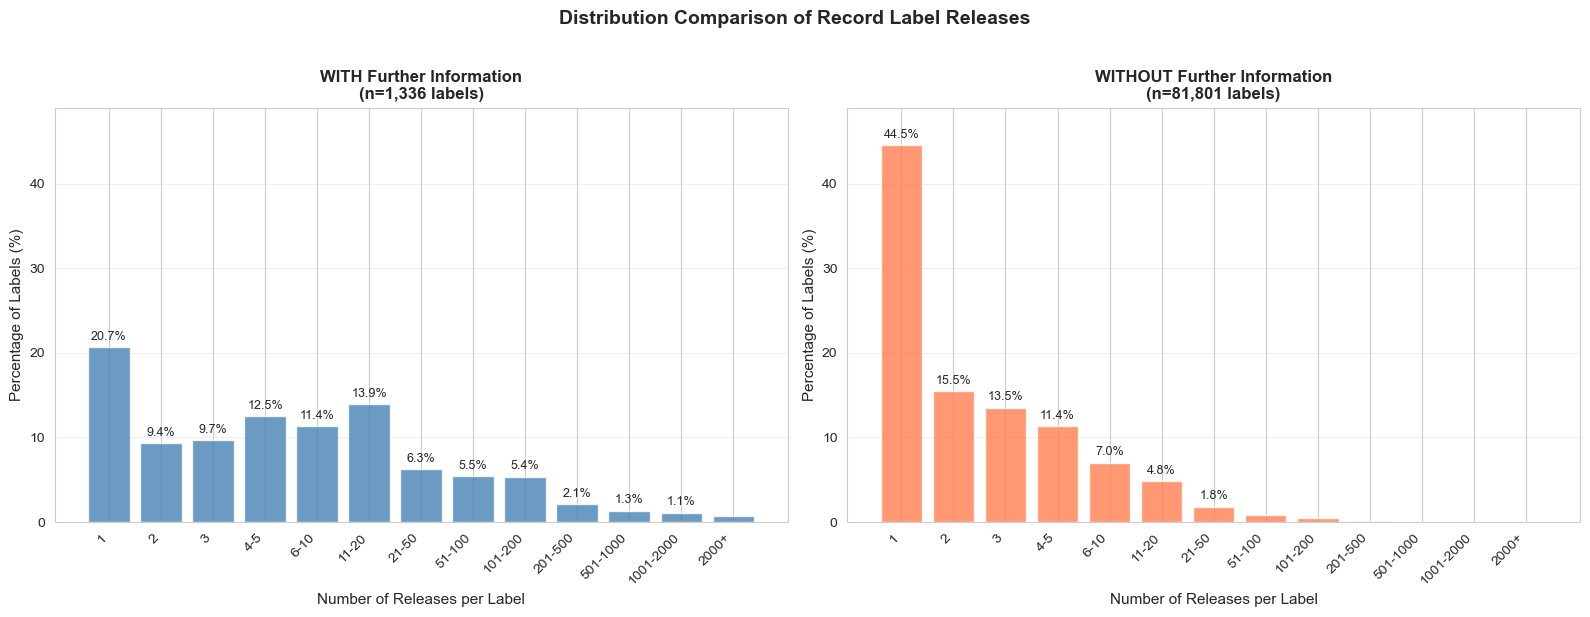

In [20]:
# Create side-by-side distribution comparison with normalized y-axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Define consistent bins for both plots
bins = [1, 2, 3, 5, 10, 20, 50, 100, 200, 500, 1000, 2000, 5000]
labels = ['1', '2', '3', '4-5', '6-10', '11-20', '21-50', '51-100', 
          '101-200', '201-500', '501-1000', '1001-2000', '2000+']

# Categorize the data
def categorize_counts(counts, bins):
    categories = pd.cut(counts, bins=bins + [np.inf], labels=labels, right=False)
    return categories.value_counts().reindex(labels, fill_value=0)

cat_with_info = categorize_counts(label_counts_with_info, bins)
cat_no_info = categorize_counts(label_counts_no_info, bins)

# Convert to percentages for normalization
pct_with_info = (cat_with_info / cat_with_info.sum()) * 100
pct_no_info = (cat_no_info / cat_no_info.sum()) * 100

# Plot 1: With further information
x = np.arange(len(labels))
bars1 = ax1.bar(x, pct_with_info, color='steelblue', alpha=0.8)
ax1.set_xlabel('Number of Releases per Label', fontsize=11)
ax1.set_ylabel('Percentage of Labels (%)', fontsize=11)
ax1.set_title(f'WITH Further Information\n(n={len(label_counts_with_info):,} labels)', 
              fontsize=12, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=45, ha='right')
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars for clarity
for bar, val in zip(bars1, pct_with_info):
    if val > 1:  # Only show labels for bars > 1%
        ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{val:.1f}%', ha='center', va='bottom', fontsize=9)

# Plot 2: Without further information  
bars2 = ax2.bar(x, pct_no_info, color='coral', alpha=0.8)
ax2.set_xlabel('Number of Releases per Label', fontsize=11)
ax2.set_ylabel('Percentage of Labels (%)', fontsize=11)
ax2.set_title(f'WITHOUT Further Information\n(n={len(label_counts_no_info):,} labels)', 
              fontsize=12, fontweight='bold')
ax2.set_xticks(x)
ax2.set_xticklabels(labels, rotation=45, ha='right')
ax2.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, val in zip(bars2, pct_no_info):
    if val > 1:  # Only show labels for bars > 1%
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{val:.1f}%', ha='center', va='bottom', fontsize=9)

# Make y-axes comparable
max_pct = max(pct_with_info.max(), pct_no_info.max()) * 1.1
ax1.set_ylim(0, max_pct)
ax2.set_ylim(0, max_pct)

plt.suptitle('Distribution Comparison of Record Label Releases', 
             fontsize=14, y=1.02, fontweight='bold')
plt.tight_layout()
plt.show()